Let's begin by importing the necessary modules. We'll use matplotlib for plotting, pytorch as our machine learning framework, the time module for tracking the length of calculations, and numpy for array manipulations. 

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

Next, let's acquire and load the MNIST dataset. Since this is a common dataset, the torchvision module has a class that simplifies this procedure. The following lines of code downloads the MNIST dataset, which is conveniently divided into a test and training set. The dataset is stored in the directory assigned to ``data_dir``. 

The MNIST dataset provides images in a Python Image Library (PIL) format. We'll have torch automatically apply a transform to these images to convert them to tensors.

In [2]:
data_dir = './data'
pil2tnsr = torchvision.transforms.ToTensor()

train = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=pil2tnsr)
test = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=pil2tnsr)

print(f'Number of images in training set: {len(train)}')
print(f'Number of images in test set: {len(test)}')


Number of images in training set: 60000
Number of images in test set: 10000


Now that we have the MNIST dataset, let's see what images look like. The variable ``index`` specifies an image number in our training set. Change it to explore other entries in the dataset.

Image label: 3
Image size: (28, 28)


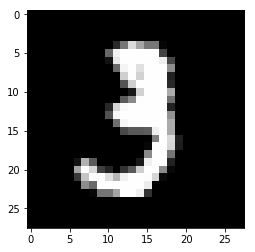

In [3]:
index = 10
img, label = train[index]

tensr2pil = torchvision.transforms.ToPILImage()
img_pil = tensr2pil(img)

plt.figure()
plt.imshow(img_pil)

print(f'Image label: {label}')
print(f'Image size: {img_pil.size}')

PyTorch provides useful tools to simplify loading and processing our data. Since we used torchvision to get the MNIST dataset,  ``train`` and ``test`` are already objects which PyTorch recognizes as datasets. We can pass them to DataLoader, which simplifies iterating through the dataset. Setting batch_size to 8 means we'll iterate through 8 images/labels at a time, and setting shuffle to True means that data is shuffled after we have iterated through the entire dataset.

In [4]:
train_loader = DataLoader(train, batch_size=8, shuffle=True)
test_loader = DataLoader(test, batch_size=8, shuffle=True)

Here we define our neural network. We use a fairly simple convolutional neural network architecture. The first part of the network has three repetitions of a convolutional layer with a ReLU activation followed by a maxpooling layer. Afterwards, there are two fully connected layers with a ReLU activation between them.

![title](nn_relu.png)

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.dense1 = nn.Linear(64, 64)
        self.dense2 = nn.Linear(64, 10)
        self.maxpool1 = nn.MaxPool2d((2, 2), stride=(2,2))
        
        
    def forward(self, x):
        #Conv/pool: (Batch size, 1, 28,28 ) -> (Batch size, 32, 24, 24) -> (Batch size, 32, 12, 12)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
        #Conv/pool: (Batch size, 32, 12, 12) -> (Batch size, 32, 8, 8) -> (Batch size, 32, 4, 4)
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        
        #Conv/pool: (Batch size, 32, 4, 4) -> (Batch size, 64, 2, 2) -> (Batch size, 64, 1, 1)
        x = F.relu(self.conv3(x))
        x = self.maxpool1(x)
        
        #Flatten: (Batch size, 64, 1, 1) -> (Batch size, 64*1*1)
        x = x.view(-1, 64)
        
        #Dense Layer 1: (Batch size, 64) -> (Batch size, 64)
        x = F.relu(self.dense1(x))
        
        #Dense Layer 2: (Batch size, 64) -> (Batch size, 10)
        x = self.dense2(x)
        
        return x
        

Let's instantiate our neural network. We'll also need to choose a loss function. Here we've selected Cross Entropy Loss, which is appropriate when you want your neural network to assign your input to one of several classes. We've selected the Adam optimization algorithm to optimize our network weights such that they minimize our loss function. 

In [6]:
model = Net()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

We have everything we need to go. This code iterates through our data, comparing the model prediction with the labels, and updating our weights to improve our neural networks ability. The ``num_epochs`` parameters determine how many time we cycle through our dataset.

In [7]:

torch.manual_seed(1)

num_epochs = 2 

#Initalize counters
running_loss = 0.0
correct = 0.0
total = 0.0

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    t_start = time.time()
    
    #Iterate through mini-batches
    for i, data in enumerate(train_loader,0):
        
        #Optimize the neural network
        inputs, labels = data
        y_pred = model(inputs)
        loss = loss_function(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Track the accuracy of its predictions
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        #Track the loss function, and output it regularly
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'Loss: {running_loss/2000}')
            running_loss = 0.0
        
    
    print(f'Finished in {time.time() - t_start:.2f}s')
    print(f'Accuracy on train set: {100*correct/total}')
    
    running_loss = 0.0
    correct = 0.0
    total = 0.0
            
        
    

Epoch: 1/2
Loss: 0.30464214020967484
Loss: 0.1003953853920102
Loss: 0.0807381663620472
Finished in 107.92s
Accuracy on train set: 95.54833333333333
Epoch: 2/2
Loss: 0.04743631257861853
Loss: 0.05301460570842027
Loss: 0.05167941872775555
Finished in 100.07s
Accuracy on train set: 98.435


Great, our neural network is performing well. After 2 epochs of training, our neural network can correctly label images in the training set with 98.4% accuracy. How does it do on data it hasn't seen before? Let's check it's performance on the test set.

In [8]:
correct = 0.0
total = 0.0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        y_pred = model(inputs)
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy on test set: {100*correct/total}')

Accuracy on test set: 98.85


We see a slightly higher accuracy on the test set than on the training set. This means we haven't overfitted the model, or in other words, in generalizes well. 

Finally, let's see our predictions. 

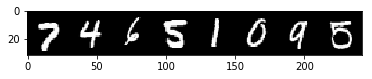

tensor([7, 4, 6, 5, 1, 0, 9, 5])


In [9]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))
plt.show()

print(labels)

There you have it, a fully trained and functioning neural network capable of identifying handwritten digits with 98% accuracy. Similar networks have been deployed before to help read addresses on envelopes and writing on cheques.

Let's summarize the ground we covered in this notebook:
1. Loading Data
2. Creating a neural network
3. Selecting a loss function
4. Optimizing your model
5. Calculating the train and test set accuracy
6. Making predictions with your model



The process used in this notebook is typical of machine learning projects. The code here is a good starting template for your own projects!